### 피크치 검출 (Scipy find_peaks())

- 피크(Peak)란? => 가장 높은 값을 의미함.

- find_peaks() 는 두 개의 결과값을 반환한다. => peaks, properties = find_peaks(value)

##### Parameter

- find_peaks()에는 여러 가지 파라미터들이 존재함.

- find_peaks(value, height) => height에 하나의 값이 있다면, 해당 값보다 큰 threshold를 찾는다. [0, 10] 처럼 범위로 설정하여 0~10 사이의 값 중 피크치를 찾는 것도 가능함.

- distance => 서로 인접한 피크치 사이의 최소 수평 거리 (더 작은 피크치가 제거됨.) => 피크의 주기성을 알고 있을 때 매우 유용함. 

##### Returns

- peaks => 해당 조건을 전부 만족하는 Peak값

- properties => 해당 조건에 만족하는 피크의 속성을 반환하는 딕셔너리 형태

> properties['peak_heights'] => 피크치의 높이

> 등등 있음.



<hr>

## Firebase로 데이터 가져오기

In [2]:
# firebase url설정과 비공개 key 세팅

import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from firebase_admin import db

if not firebase_admin._apps:
    cred = credentials.Certificate("gait-analysis-7350b-firebase-adminsdk-czbst-e78dd10970.json")
    firebase_admin.initialize_app(cred,{'databaseURL':'https://gait-analysis-7350b-default-rtdb.asia-southeast1.firebasedatabase.app/230128_jihun'})

In [3]:
# firebase로 값 저장, 변경, 가져오기 메서드

import numpy as np
import pandas as pd


#해당 filename에 해당하는 테이블 가져오기.
def getDataName(filename):
    dir = db.reference(filename)
    data = dir.get()
    df = pd.DataFrame(data)
    return df


#getData로 가져온 df를 다른 이름으로 저장하기.
def setData(df, name, test_number, stance, inital_swing, heel_strike, toe_off, step_velocity):     #df, "jihun", 5 =? jihun's test5
    dict = {}

    dict.update({'Roll' : df['Roll'].values.tolist()})
    dict.update({'Inital Swing' : inital_swing})    #inital Swing ( one Point)
    dict.update({'Filtered_Roll' : df['filtered_roll'].values.tolist()})
    dict.update({'Time' : df['Time'].values.tolist()})
    dict.update({'Heel Strike' : heel_strike})
    dict.update({'Toe Off' : toe_off})
    dict.update({'Stance' : stance})
    dict.update({'Step Velocity' : step_velocity})

    # name = input()
    new_dir = db.reference(name + "/" + "test" + str(test_number))
    new_dir.update(dict)

    

#디폴트로 저장되는 테이블 이름 "input"을 df로 가져오기
def getData(directoty):    
    dir = db.reference(directoty) #데이터베이스에 저장되어있는 데이터 이름
    data = dir.get()
    
    dir = db.reference()
    
    data_list = np.concatenate(data).tolist()
    
    for i in range(0,len(data_list)):
        data_list[i] = data_list[i].split(',')
    
    
    df = pd.DataFrame(data_list)
    df.columns = ['Roll','Pitch','Time']
    df = df.astype('float') 

    df['Time'] = df['Time'].apply(lambda x: x/1000)
    first_time = df['Time'].loc[0]
    df['Time'] = df['Time'].apply(lambda x: x-first_time)
    
    df = df.loc[200:,:]
    
    return df

#set_External_GaitSection(새로 추가하려는 데이터, 보행 구간(Heel Strike, Heel off등))
def set_External_GaitSection(data, section):
    search = db.reference("Total")
    search_section = db.reference("Total/"+ section)
    new_data = search_section.get()
    if new_data != None: 
        for value in data:
            new_data.append(value)
        search.update({section:new_data})
    else:
        search.update({section:data})

In [30]:
ref = db.reference()
ref.delete()

<hr>

### Get Gait Parameter

- Heel Strike Point (최고점)

- Toe OFf Point (최저점)

- Mid Stance (평상시 Stance 상태)

1. Stance 상태일 때의 Roll값의 평균을 구함.

2. 전체 데이터를 기준으로 평균을 전부 뺌. (Stance 상태의 평균을 0으로 기준 삼음) => 표준화

3. 필터링, 표준화된 데이터를 firebase에 저장함.

In [57]:
# 보행 주기에서의 Roll값의 최고점(Heel Strike)과 최저점(Toe Off) 구하기
# Scipy의 find_peaks를 이용함.
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

#최고점 (Heel Strike) 구하기
def getHeelStrikePoint(df):
    high_point, _ = find_peaks(df['filtered_roll'], distance=12, height=10)#피크치의 최소거리는 최소 25개
    high_point = high_point.tolist()

    return high_point

#최저점 (Toe Off) 구하기
def getToeOffPoint(df):
    df2 = df["filtered_roll"].apply(lambda x: -(x))   #거꾸로 뒤집은 후 피크치 구하기(최저점 구하기)
    low_point, _ = find_peaks(df2, distance=12, height= 5) #distance는 임의의 적당한 값이 25이고, 실험을 진행하며 적당한 값을 찾아야 함.
    low_point = low_point.tolist()
    
    return low_point


#가만히 있을 때의 정보 3가지 return => 1. mean 2. threshold_max, 3. threshold_min (Mid Stance)r
def getStopStancePoint(df, start_point, end_point):
    before_walking = df.iloc[:start_point]['filtered_roll'][(df.iloc[0:start_point]['filtered_roll'] > -140) & (df.iloc[0:start_point]['filtered_roll'] < -100)].index.tolist()
    after_walking = df.iloc[end_point:]['filtered_roll'][(df.iloc[end_point:]['filtered_roll'] > -120) & (df.iloc[end_point:]['filtered_roll'] < -100)].index.tolist()

    after_walking = []       #일단 뒤에꺼는 안넣음.
    return before_walking + after_walking
 


def stopStanceMean(df, stance_state):
    sum = 0
    for x in stance_state:
        sum += df.iloc[x]['filtered_roll']
    
    return sum / len(stance_state)

# Stance 상태일 때의 ROll값을 0으로 기준삼음. (표준화)
def standardization(df, stance_mean):
    for i in range(0,len(df['filtered_roll'])):
        df['filtered_roll'].iloc[i] -= stance_mean
    print(df['filtered_roll'].iloc[i])
    new_df = df

    return new_df

#HighPoint와 LowPoint를 포함한 데이터프레임 플로팅
def plotting_pivot_point(df, df_high_point, df_low_point):
    # plt.plot(df['Time'], df['Roll'])
    # plt.plot(df['Time'][df_high_point], df['Roll'][df_high_point], 'x')
    # plt.plot(df['Time'][df_low_point], df['Roll'][df_low_point], 'x')
    xlabel = df.index
    plt.plot(xlabel, df['filtered_roll'])
    plt.scatter(df_high_point, df['filtered_roll'][df_high_point], c='r')
    plt.scatter(df_low_point, df['filtered_roll'][df_low_point], c='g')

    plt.show()


<hr>

### 23년 03월 02일에 진행한 Test Analysis

- Delay(100) => Delay(50) 으로 변경	

- 칼만 필터 (Kalman Filter)을 통하여 저주파 데이터에 대한 노이즈 최소화 (보정)

### Kalman Filter

- 칼만 필터는 무릎의 떨림, 센서의 오차값 등등 불확실성이 존재하는 데이터를 예측하여 보정하여 노이즈를 최소화해주는 필터이다.

- 칼만 필터는 측정 받은 이전 value, 예측한 value, 실제 value를 통하여 보정을 함.

1. 이전 데이터를 가지고 다음에 들어올 데이터에 대한 예측값을 설정함.

2. 실제 입력 데이터값이 들어옴.

3. 1번과 2번을 비교하여 최적의 출력값을 추정함. (예측)

- 칼만 필터에는 선형 칼만 필터, 비선형 칼만 필터, 확장 칼만 필터 등등 다양한 칼만 필터들이 존재한다. 

- 우리가 현재 분석하고 있는 **Roll**값은 3축에 대한 가속도, 각속도의 값에 아크탄젠트로 계산을 하기 때문에 **비선형 데이터**에 속하므로, **확장 칼만 필터(Extended kalman filter)**를 사용해야 한다.


### Extended Kalman Filter (EKF)

- 비선형 데이터 모델에 대한 표준 칼만 필터의 확장형이다. 

- EKF는 비선형 모델을 매 순간마다 미분을 통하여 선형 함수로 만들어, 표준 칼만 필터를 적용시키는 것이 **Extended Kalman Filter**이다.

- EKF에서는 **jacobian**이라는 개념이 사용됨.

- jacobian은 매순간 모든 변수들에 대해 미분을 해주어 선형화된 값을 얻어낸다.


### filterpy의 ExtendedKalmanFilter 라이브러리

- 많은 소프트웨어 라이브러리에서 사용중인 라이브러리로, 비선형 데이터를 선형으로 변환 후, 칼만 필터를 적용시킴.

##### Parameter

- 상태 벡터 정의 => Roll 데이터가 센서의 Roll 각도를 나타낸다. 상태 벡터에서는 각도와 속도가 포함되어야하므로, 상태 벡터의 크기는 (2, 1)이 되어야 한다.

- 측정 벡터 정의 => 측정 벡터에는 센서의 Roll의 각도가 포함되어야 합니다. 따라서 측정 벡터의 크기는 (1, 1)이어야 합니다.

- 상태 전이 함수 => 상태 전이 함수는 시간이 경과함에 따라 어떻게 value가 진행되는지.

##### Extended Kalman Filter의 효과

- 예상 Roll의 value에서 노이즈가 감소함. => EKF는 측정값과 시스템 모델(예측값)을 모두 사용하여 상태를 추정하기 때문에 원시 측정 값보다 부드럽고 정확하게 측정할 수 있음.

- Roll Rate 변호에 대한 response를 개선할 수 있음.

- 정확도와 신뢰성 향상.


In [5]:
import numpy as np
from filterpy.kalman import ExtendedKalmanFilter

"""
1. 상태 전이 행렬 (A)와 제어 입력 행렬 (B) => 이 행렬은 시간의 경과에 따라 어떻게 진행되는지 정의함. 하지만 해당 시스템 외부에서 힘이나 토크를 가하는 경우는 없기에 행렬은 0으로 정의

2. 측정 매트릭스(C) -> 이 행렬은 측정과 관련된 방식의 정의함. 해당 Roll에 대한 value는 직접 측정하므로 1이 됨.

3. 초기 상태 벡터(x0) 및 공분산 행렬(P0) => 해당 변수들은 상태 및 해당 불확실성의 초기 추정치를 정의합니다. 초기 Roll의 각도가 첫 번째 측정값과 같다 가정함. 공분산 행렬은 초기 추정치에 대한 신뢰도를 반영하기 위해 작은 값으로 설정됩니다.

4. 공정 잡음 공분산 행렬(Q) 및 측정 잡음 공분산 행렬(R): 이 행렬은 각각 시스템 모델과 측정의 불확실성 양을 정의합니다. 이 경우 롤 속도와 롤 각도 측정에 약간의 불확실성이 있다고 가정합니다.

5. 측정 함수(Hx) 및 해당 야코비안(HJacobian): 이 함수는 각각 상태가 상태 변수에 대한 측정 및 도함수와 어떻게 관련되는지 정의합니다. 이 경우 측정 함수는 단순히 롤 각도를 반환하고 Jacobian은 측정 행렬 C와 같습니다.

"""
def extended_kalman_filter(roll_data):
    # Define time step
    dt = 0.02

    # Define state transition matrix => 상태 전이 
    A = np.array([[1, dt], [0, 1]])

    # Define control input matrix => 제어 입력 행렬
    B = np.array([[0], [0]])

    # Define measurement matrix 측정 벡터
    C = np.array([[1, 0]])

    # Define initial state vector and covariance matrix
    x0 = np.array([[roll_data[0]], [0]])
    P0 = np.diag([0.01, 0.01])

    # Define process noise covariance matrix
    Q = np.diag([0.01, 0.01])

    # Define measurement noise covariance matrix
    R = np.diag([0.01])

    # Initialize ExtendedKalmanFilter object
    ekf = ExtendedKalmanFilter(dim_x=2, dim_z=1)

    # Define measurement function and its Jacobian as functions outside of the ExtendedKalmanFilter class
    def Hx(x):
        return np.dot(C, x)

    def HJacobian(x):
        return C

    ekf.x = x0
    ekf.P = P0
    ekf.Q = Q
    ekf.R = R
    ekf.F = A
    ekf.B = B
    ekf.Hx = Hx
    ekf.HJacobian = HJacobian

    # Create empty array to hold estimated roll values
    est_roll = np.zeros_like(roll_data)

    # Run the filter
    for i in range(len(roll_data)):
        # Predict the state vector and covariance matrix
        ekf.predict()

        # Update the state vector and covariance matrix with the measurement
        ekf.update(np.array([roll_data[i]]), HJacobian=HJacobian, Hx=Hx)

        # Store the estimated roll value
        est_roll[i] = ekf.x[0, 0]

    return est_roll


<hr>

보행에 대한 데이터

In [124]:
#데이터 읽어오기
import pandas as pd

df = pd.read_csv('../data/230328 Test/Kim seungjun5.csv')
df

,Roll,Time
0,-130.97,0.1999
1,-130.26,0.3030
2,-131.79,0.4091
3,-131.44,0.5129
4,-131.65,0.6140
...,...,...
102,-125.16,10.7848
103,-123.02,10.8867
104,-120.77,10.9890
105,-122.53,11.0952


In [125]:
#칼만필터 적ㅛㅇ하기
roll_data = df['Roll'].values
filtered_roll = extended_kalman_filter(roll_data)

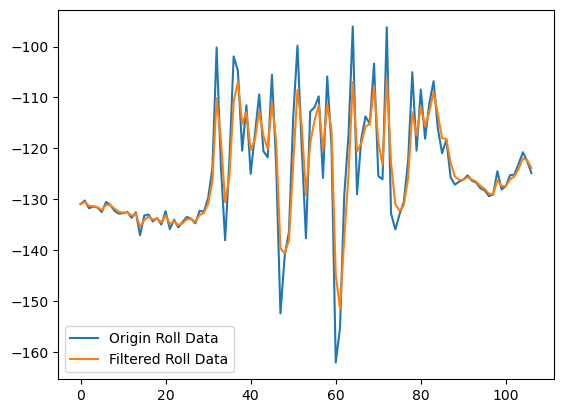

In [126]:
#원래 데이터와 칼만필터 적용한 데이터 플로팅 하기
import matplotlib.pyplot as plt

# Plot origin roll data
plt.plot(roll_data, label='Origin Roll Data')

# Plot filtered roll data
plt.plot(range(len(filtered_roll)), filtered_roll, label='Filtered Roll Data')

plt.legend()
plt.show()

### Extended Kalman Filter Data

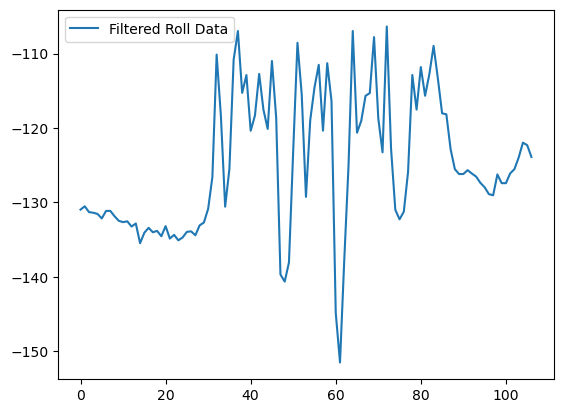

In [127]:
plt.plot(filtered_roll, label='Filtered Roll Data')
plt.legend()

plt.show()

In [128]:
#데이터프레임에 kalman filter 적용된 데이터 넣기
df['filtered_roll'] = filtered_roll

In [129]:
df

,Roll,Time,filtered_roll
0,-130.97,0.1999,-130.970000
1,-130.26,0.3030,-130.526139
2,-131.79,0.4091,-131.308811
3,-131.44,0.5129,-131.390158
4,-131.65,0.6140,-131.551142
...,...,...,...
102,-125.16,10.7848,-125.529033
103,-123.02,10.8867,-123.970505
104,-120.77,10.9890,-121.968303
105,-122.53,11.0952,-122.304404


In [130]:
df_stancePoint = getStopStancePoint(df, 30, 140)

mean = stopStanceMean(df,df_stancePoint)
df = standardization(df,mean)

9.159679087514434


In [131]:
df

,Roll,Time,filtered_roll
0,-130.97,0.1999,2.079700
1,-130.26,0.3030,2.523561
2,-131.79,0.4091,1.740889
3,-131.44,0.5129,1.659542
4,-131.65,0.6140,1.498558
...,...,...,...
102,-125.16,10.7848,7.520667
103,-123.02,10.8867,9.079195
104,-120.77,10.9890,11.081397
105,-122.53,11.0952,10.745296


### 가만히 서있을 때, Toe Off 지점, Heel Strike 지점 인덱스와 벨류 구하기.

In [134]:
#Get Heel Strike and Toe Off Points and StancePoint
df_heelStrikePoint = getHeelStrikePoint(df)[:-1]
df_toeOffPoint= getToeOffPoint(df)

#Heel Strike, Stance, ToeOff Value
df_stanceValue = df['filtered_roll'][df_stancePoint].tolist()
df_heelStrikeValue = df['filtered_roll'][df_heelStrikePoint].tolist()

[]

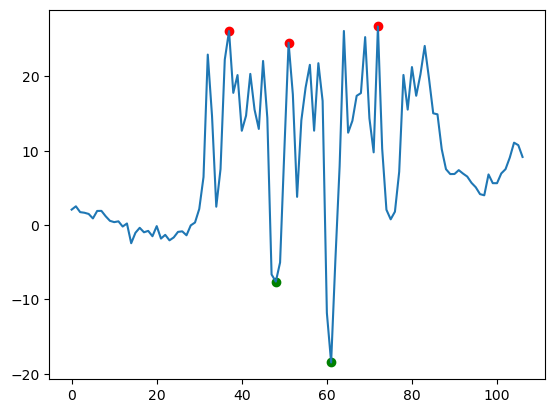

In [135]:
xlabel = df.index
plt.plot(xlabel, df['filtered_roll'])
plt.scatter(df_heelStrikePoint, df['filtered_roll'][df_heelStrikePoint], c='r')
plt.scatter(df_toeOffPoint, df['filtered_roll'][df_toeOffPoint], c='g')

plt.plot()

### Toe Off의 첫번째 인덱스는 Inital Swing, 이걸 제외한 나머지는 다시 Toe Off로

In [136]:
df_initalSwingPoint = [df_toeOffPoint[0]]     #firebase로 넣기 위해서는 float형이 아닌 list형으로 넣어야함.
# df_toeOffPoint = df_toeOffPoint[1:]

df_toeOffValue = df['filtered_roll'][df_toeOffPoint].tolist()
df_initalSwingValue = df['filtered_roll'][df_initalSwingPoint].tolist()

df_initalSwingValue = [3.31]

[]

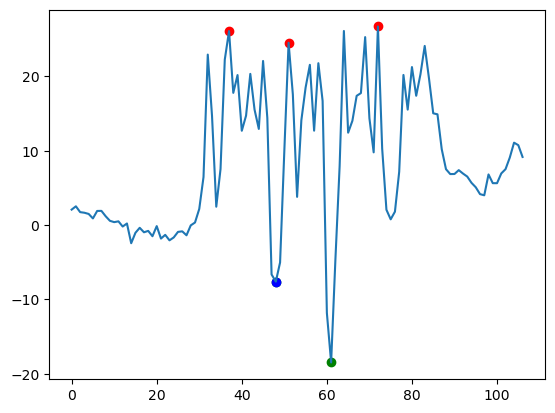

In [137]:
xlabel = df.index
plt.plot(xlabel, df['filtered_roll'])
plt.scatter(df_heelStrikePoint, df['filtered_roll'][df_heelStrikePoint], c='r')
plt.scatter(df_toeOffPoint, df['filtered_roll'][df_toeOffPoint], c='g')
plt.scatter(df_initalSwingPoint, df['filtered_roll'][df_initalSwingPoint], c='b')

plt.plot()

### 오른발의 **Heel Strike**로 보행 주기 구하기

In [138]:
step_velocity = []
for i in range(len(df_heelStrikePoint)-1):
    # gait_time.append(jh_test1['Time'][jh_test1_heelStrikePoint[i+1]] - jh_test1['Time'][jh_test1_heelStrikePoint[i]])
    step_velocity.append(df['Time'][df_heelStrikePoint[i+1]] - df['Time'][df_heelStrikePoint[i]])


In [139]:
#Check Parameters Values

# print(jh_test1_heelStrikeValue)
print(df_heelStrikeValue)
print(df_toeOffValue)
print(df_initalSwingValue)

[26.087133443284046, 24.51045507668813, 26.70249088964549]
[-7.601689401557621, -18.472965654007112]
[3.31]


### To Firebase

In [140]:
# Data To Firebase

setData(df, "Kim Seungjin", 5, df_stanceValue, df_initalSwingValue, df_heelStrikeValue, df_toeOffValue, step_velocity)

# Data To Firebase
set_External_GaitSection(df_heelStrikeValue, "Heel Strike")
set_External_GaitSection(df_stanceValue, "Stacne State")
set_External_GaitSection(df_toeOffValue, "Toe Off")
set_External_GaitSection(df_initalSwingValue, "Inital Swing")
set_External_GaitSection(step_velocity,"Step Velocity") 

노란색 플로팅은 stance상태일때의 values

빨간색 포인트는 Heel Strike 지점 (제일 높은 값)

초록색 포인트는 Toe Off 지점 (제일 작은 값)

- 노란 플롯 => stance 상태 

- 빨간 scatter => Heel Strike (최고점)

- 파랑 scatter => Inital Swing

- 초록 scatter => Toe Off (최저점)

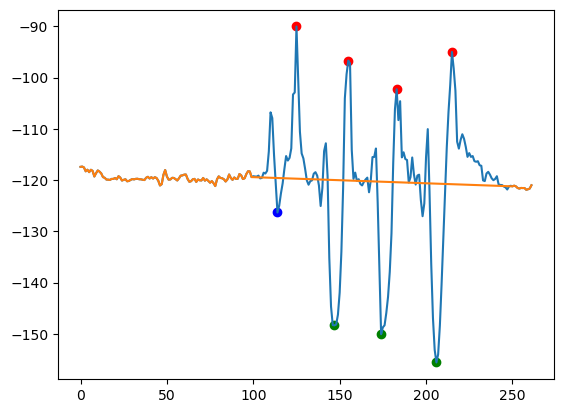

In [657]:
# extended kalman filter data plotting
# stance data plotting
# heel strike and toe off point and Inital Swing plotting

xlabel = df.index
plt.plot(xlabel, df['filtered_roll'])
plt.plot(df_stancePoint, df['filtered_roll'][df_stancePoint])
plt.scatter(df_heelStrikePoint, df['filtered_roll'][df_heelStrikePoint], c='r')
plt.scatter(df_toeOffPoint, df['filtered_roll'][df_toeOffPoint], c='g')
plt.scatter(df_initalSwingPoint, df['filtered_roll'][df_initalSwingPoint], c='b')

plt.show()
